### Exploring the Dataset

##### Importing all the necessary modules and reading the data

In [ ]:
import pandas as pd
import numpy as np
from evaluate import load

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback

import torch

from sklearn.decomposition import PCA
import umap

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
reviews = pd.read_json('data\Yelp-JSON\Yelp JSON\Extracted\yelp_academic_dataset_review.json', lines=True, nrows=500000)
print(reviews.shape)
reviews.head()

(500000, 9)


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


##### exploring the data and preprocessing

In [3]:
reviews['length'] = reviews['text'].apply(lambda x: len(x.split()))

reviews['date'] = pd.to_datetime(reviews['date'])
reviews['year'] = reviews['date'].dt.year
reviews['month'] = reviews['date'].dt.month 
reviews['day'] = reviews['date'].dt.day

reviews.drop(columns=['date'], inplace=True)

In [4]:
reviews.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
stars,500000.0,3.806634,1.418262,1.0,3.0,4.0,5.0,5.0
useful,500000.0,1.028570,2.409103,0.0,0.0,0.0,1.0,320.0
funny,500000.0,0.285922,1.245599,0.0,0.0,0.0,0.0,284.0
cool,500000.0,0.410568,1.437532,0.0,0.0,0.0,0.0,164.0
length,500000.0,102.903146,95.783358,1.0,41.0,73.0,131.0,1006.0
year,500000.0,2015.718264,2.851570,2005.0,2014.0,2016.0,2018.0,2022.0
month,500000.0,6.383990,3.380115,1.0,3.0,6.0,9.0,12.0
day,500000.0,15.712476,8.811181,1.0,8.0,16.0,23.0,31.0


In [5]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   review_id    500000 non-null  object
 1   user_id      500000 non-null  object
 2   business_id  500000 non-null  object
 3   stars        500000 non-null  int64 
 4   useful       500000 non-null  int64 
 5   funny        500000 non-null  int64 
 6   cool         500000 non-null  int64 
 7   text         500000 non-null  object
 8   length       500000 non-null  int64 
 9   year         500000 non-null  int32 
 10  month        500000 non-null  int32 
 11  day          500000 non-null  int32 
dtypes: int32(3), int64(5), object(4)
memory usage: 40.1+ MB


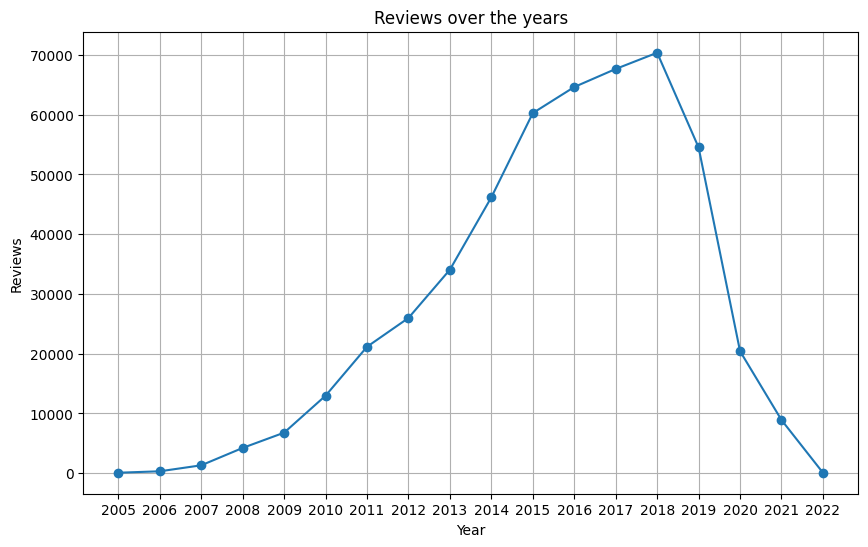

In [6]:
reviews_per_year = reviews.groupby('year').size().reset_index(name='count')

plt.figure(figsize=(10, 6))
plt.plot(reviews_per_year['year'], reviews_per_year['count'], marker='o', linestyle='-')
plt.title('Reviews over the years')
plt.xlabel('Year')
plt.ylabel('Reviews')
plt.xticks(reviews_per_year['year'])
plt.grid()
plt.show()

In [7]:
reviews = reviews[(reviews['year'] >= 2008) & (reviews['year'] <= 2017)]

reviews = reviews[reviews['length'] >= 10]

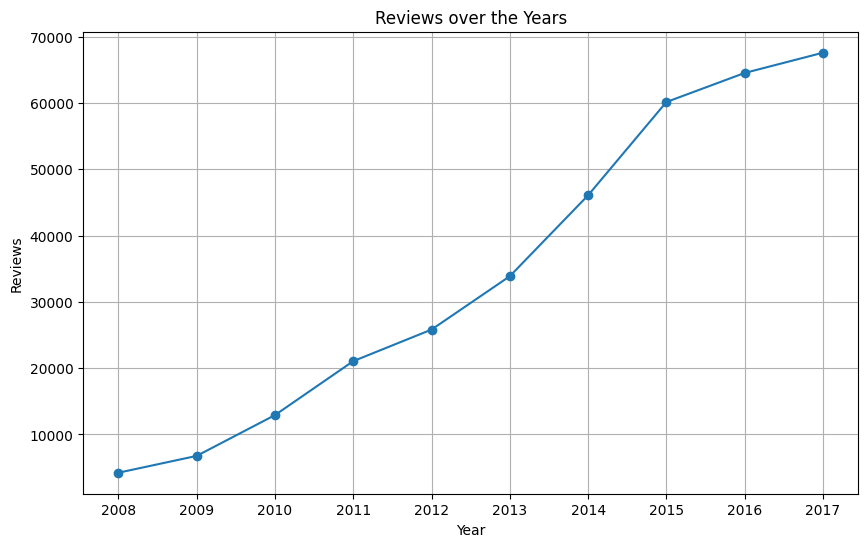

In [8]:
# time series analysis - reviews per year
reviews_per_year = reviews.groupby('year').size().reset_index(name='count')

# plotting
plt.figure(figsize=(10, 6))
plt.plot(reviews_per_year['year'], reviews_per_year['count'], marker='o', linestyle='-')
plt.title('Reviews over the Years')
plt.xlabel('Year')
plt.ylabel('Reviews')
plt.xticks(reviews_per_year['year'])
plt.grid()
plt.show()

### Creating Binary Sentiment Labels

In [9]:
reviews['sentiment'] = reviews['stars'].apply(lambda x: 1 if x >= 4 else 0)
reviews['sentiment'].value_counts()

sentiment
1    233977
0    109044
Name: count, dtype: int64

### Startified Train Test Split

In [10]:
train, test = train_test_split(
    reviews,
    test_size=0.2,
    stratify=reviews['sentiment']
)

In [11]:
import torch
print(torch.__version__)
print("CUDA Available:", torch.cuda.is_available())

2.7.1+cu118
CUDA Available: False


### Text Tokenization

In [35]:
tokenizer = AutoTokenizer.from_pretrained('prajjwal1/bert-tiny')

def tokenize_function(example):
    return tokenizer(
        example,
        padding='max_length',
        truncation=True,
        max_length=256,
        return_tensors='pt'
    )

train_encodings = tokenizer(
    train['text'].tolist(),
    padding='max_length',
    truncation=True,
    max_length=256,
    return_tensors='pt'
)

test_encodings = tokenizer(
    test['text'].tolist(),
    padding='max_length',
    truncation=True,
    max_length=256,
    return_tensors='pt'
)

c:\Users\sachith.j\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\sachith.j\.cache\huggingface\hub\models--prajjwal1--bert-tiny. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


### Create PyTorch Dataset

In [36]:
class PyTorchDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {
            key: val[idx] for key, val in self.encodings.items()
        }
        item['labels'] = torch.tensor(self.labels[idx])
        return item

In [37]:
train_dataset = PyTorchDataset(train_encodings, train['sentiment'].tolist())
test_dataset = PyTorchDataset(test_encodings, test['sentiment'].tolist())

### 1. Bert Model - Hugging Face

##### Import and train Bert Model

In [38]:
# Binary classification → num_labels=2
model = AutoModelForSequenceClassification.from_pretrained(
    'prajjwal1/bert-tiny',
    num_labels=2
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    fp16=True,
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    save_strategy="epoch",
    eval_strategy="epoch",
    logging_dir='./logs',
    logging_steps=100,
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

trainer.train()

Epoch,Training Loss,Validation Loss
1,0.265700,0.237744


TrainOutput(global_step=17151, training_loss=0.27361558465233116, metrics={'train_runtime': 6905.552, 'train_samples_per_second': 39.738, 'train_steps_per_second': 2.484, 'total_flos': 174320985784320.0, 'train_loss': 0.27361558465233116, 'epoch': 1.0})

In [40]:
eval_results = trainer.evaluate()
print(eval_results)

c:\Users\sachith.j\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.23774434626102448, 'eval_runtime': 125.8145, 'eval_samples_per_second': 545.287, 'eval_steps_per_second': 8.52, 'epoch': 1.0}


#### Saving the pretrained model

In [42]:
model.save_pretrained("./models/bert_tiny_sentiment")
tokenizer.save_pretrained("./models/bert_tiny_sentiment")

('./models/bert_tiny_sentiment\\tokenizer_config.json',
 './models/bert_tiny_sentiment\\special_tokens_map.json',
 './models/bert_tiny_sentiment\\vocab.txt',
 './models/bert_tiny_sentiment\\added_tokens.json',
 './models/bert_tiny_sentiment\\tokenizer.json')

#### Load back the pretrained model

In [43]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("./models/bert_tiny_sentiment")
model = AutoModelForSequenceClassification.from_pretrained("./models/bert_tiny_sentiment")

In [46]:
text = "The food was amazing and the service was great!"

inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
outputs = model(**inputs)
logits = outputs.logits
predicted_class = logits.argmax().item()

print("Predicted Sentiment:", "Positive" if predicted_class == 1 else "Negative")


Predicted Sentiment: Positive


#### Evaluate the Bert model

In [49]:
accuracy_metric = load("accuracy")
f1_metric = load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    
    acc = accuracy_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels, average='weighted')
    
    return {
        "accuracy": acc["accuracy"],
        "f1": f1["f1"]
    }

##### F1 Score

In [51]:
# new trainer for f1 score calculation
trainerf1 = Trainer(
    model=model,
    args=training_args,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)
results = trainerf1.evaluate()
print(results)

{'eval_loss': 0.23774434626102448, 'eval_model_preparation_time': 0.001, 'eval_accuracy': 0.9040448946869761, 'eval_f1': 0.903295640976971, 'eval_runtime': 162.5732, 'eval_samples_per_second': 421.995, 'eval_steps_per_second': 6.594}


##### Confusion Matirx

c:\Users\sachith.j\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


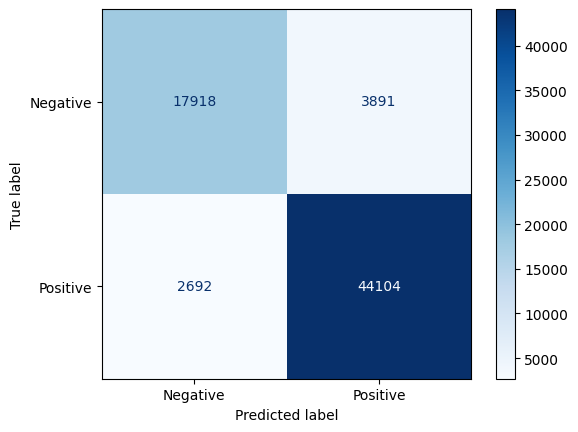

In [54]:
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap="Blues")

##### Classification Report

In [55]:
print(classification_report(labels, preds, target_names=["Negative", "Positive"]))

              precision    recall  f1-score   support

    Negative       0.87      0.82      0.84     21809
    Positive       0.92      0.94      0.93     46796

    accuracy                           0.90     68605
   macro avg       0.89      0.88      0.89     68605
weighted avg       0.90      0.90      0.90     68605



##### Confidence Histogram

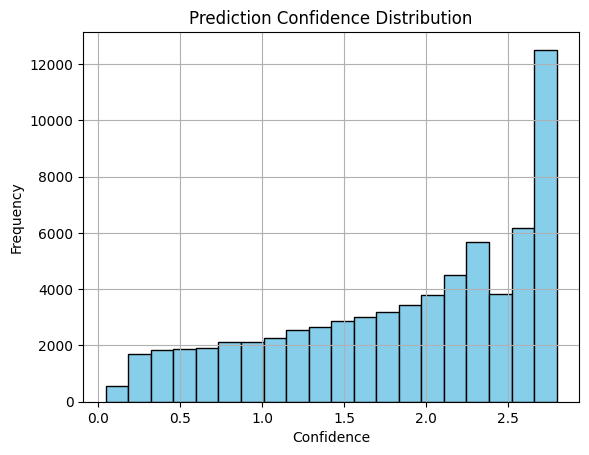

In [56]:
confidences = np.max(predictions.predictions, axis=1)

plt.hist(confidences, bins=20, color='skyblue', edgecolor='black')
plt.title("Prediction Confidence Distribution")
plt.xlabel("Confidence")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()